In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os

os.chdir('/content/gdrive/My Drive/comp-551-mini-project-3')

In [0]:
!apt-get install -qq graphviz

In [0]:
!pip install -U numpy pandas scikit-learn torch ipympl torchviz

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.16.2)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.3)
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.0.1.post2)
Requirement already up-to-date: ipympl in /usr/local/lib/python3.6/dist-packages (0.2.1)
Requirement already up-to-date: torchviz in /usr/local/lib/python3.6/dist-packages (0.0.1)


In [0]:
import sys

print(sys.version)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


In [0]:
!nvidia-smi

Mon Mar 18 18:49:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import logging
import random
import warnings
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import StratifiedShuffleSplit
from torch import nn
from torchvision import models, transforms
from torchvision.models import resnet, densenet, squeezenet
from torchviz import make_dot

In [0]:
%matplotlib inline

In [0]:
plot_dpi = 100

In [0]:
warnings.simplefilter('ignore')

In [0]:
x_tr = np.expand_dims(pd.read_pickle('./dataset/train_images.pkl'), axis=1)
x_ts = np.expand_dims(pd.read_pickle('./dataset/test_images.pkl'), axis=1)
y_tr = pd.read_csv('./dataset/train_labels.csv').values[:, 1]

num_classes = 10

In [0]:
print(x_tr.shape)
print(x_ts.shape)
print(y_tr.shape)

(40000, 1, 64, 64)
(10000, 1, 64, 64)
(40000,)


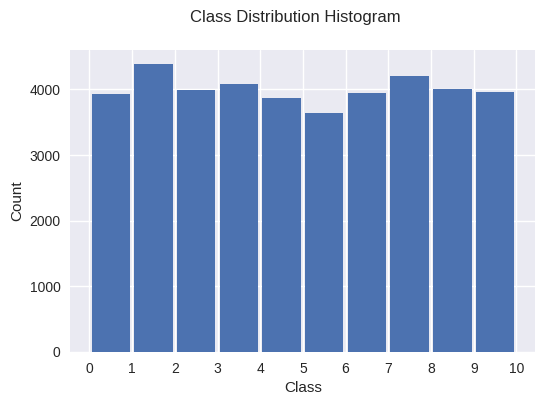

In [0]:
plt.figure(dpi=plot_dpi)
plt.suptitle('Class Distribution Histogram')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(11))
plt.hist(y_tr, bins=range(11), histtype='bar', rwidth=0.9)
plt.show()

In [0]:
num_random_samples = (5, 5)
idx = np.random.randint(0, x_tr.shape[0], num_random_samples)

In [0]:
# x_tr_org = np.copy(x_tr)
# x_tr[x_tr > 220] = 255
# x_tr[x_tr < 255] = 0

# plt.figure(dpi=plot_dpi)

# ax = plt.subplot(2, 3, 1)
# ax.set_title('Original')
# plt.imshow(x_tr_org[idx[0, 0]].squeeze().squeeze(), cmap='gray')

# ax = plt.subplot(2, 3, 2)
# ax.set_title('Thresholded')
# plt.imshow(x_tr[idx[0, 0]].squeeze().squeeze(), cmap='gray')

# min_component_size = 20
# for i, x_i in enumerate(x_tr):
#     x_i = x_i.squeeze().astype(np.uint8)
#     _, output, stats, _ = cv2.connectedComponentsWithStats(x_i, connectivity=8)

#     x_i_rm = np.zeros(output.shape)
#     for j, size in enumerate(stats[1:, -1]):  # Ignore the background
#         if size >= min_component_size:
#             x_i_rm[output == j + 1] = 255
#     x_tr[i] = x_i_rm.reshape(x_i.shape)

# ax = plt.subplot(2, 3, 3)
# ax.set_title('Removed')
# plt.imshow(x_tr[idx[0, 0]].squeeze().squeeze(), cmap='gray')

# x_tr /= 255

# ax = plt.subplot(2, 3, 4)
# ax.set_title('Normalized')
# plt.imshow(x_tr[idx[0, 0]].squeeze().squeeze(), cmap='gray')

# for i, x_i in enumerate(x_tr):
#     x_i = x_i.squeeze().astype(np.uint8)
#     _, contours, _ = cv2.findContours(x_i, 1, 2)
    
#     max_x, max_y, max_w, max_h = 0, 0, 0, 0
#     for contour in contours:
#         x_br, y_br, w_br, h_br = cv2.boundingRect(contour)
#         if w_br * h_br > max_w * max_h:
#             max_x, max_y, max_w, max_h = x_br, y_br, w_br, h_br

#     x_i_bc = np.zeros_like(x_i)
#     x_i_x, x_i_y = (x_i.shape[0] - max_h) // 2, (x_i.shape[1] - max_w) // 2
#     x_i_bc[x_i_x:x_i_x + max_h, x_i_y:x_i_y + max_w] = x_i[max_y:max_y + max_h, max_x:max_x + max_w]
#     x_tr[i] = x_i_bc

# ax = plt.subplot(2, 3, 5)
# ax.set_title('Centered')
# plt.imshow(x_tr[idx[0, 0]].squeeze().squeeze(), cmap='gray')

# x_tr = nn.functional.interpolate(torch.from_numpy(x_tr), size=(32, 32)).numpy()

# ax = plt.subplot(2, 3, 6)
# ax.set_title('Resized')
# plt.imshow(x_tr[idx[0, 0]].squeeze().squeeze(), cmap='gray')

# plt.tight_layout()

# plt.show()

In [0]:
# # Threshold
# x_tr_org = np.copy(x_tr)
# x_tr[x_tr > 220] = 255
# x_tr[x_tr < 255] = 0

# x_ts[x_ts > 220] = 255
# x_ts[x_ts < 255] = 0

In [0]:
# plt.figure(dpi=plot_dpi)
# plt.suptitle('Random samples before thresholding')
# for i in range(num_random_samples[0]):
#     for j in range(num_random_samples[1]):
#         plt.subplot(num_random_samples[0], num_random_samples[1], i * num_random_samples[1] + j + 1)
#         plt.imshow(x_tr_org[idx[i, j]].squeeze().squeeze(), cmap='gray')
# plt.show()

# plt.figure(dpi=plot_dpi)
# plt.suptitle('Random samples after thresholding')
# for i in range(num_random_samples[0]):
#     for j in range(num_random_samples[1]):
#         plt.subplot(num_random_samples[0], num_random_samples[1], i * num_random_samples[1] + j + 1)
#         plt.imshow(x_tr[idx[i, j]].squeeze().squeeze(), cmap='gray')
# plt.show()

In [0]:
# del x_tr_org

In [0]:
# # Remove dots
# x_tr_org = np.copy(x_tr)
# min_component_size = 20
# for i, x_i in enumerate(x_tr):
#     x_i = x_i.squeeze().astype(np.uint8)
#     _, output, stats, _ = cv2.connectedComponentsWithStats(x_i, connectivity=8)

#     x_i_rm = np.zeros(output.shape)
#     for j, size in enumerate(stats[1:, -1]):  # Ignore the background
#         if size >= min_component_size:
#             x_i_rm[output == j + 1] = 255
#     x_tr[i] = x_i_rm.reshape(x_i.shape)

# for i, x_i in enumerate(x_ts):
#     x_i = x_i.squeeze().astype(np.uint8)
#     _, output, stats, _ = cv2.connectedComponentsWithStats(x_i, connectivity=8)

#     x_i_rm = np.zeros(output.shape)
#     for j, size in enumerate(stats[1:, -1]):  # Ignore the background
#         if size >= min_component_size:
#             x_i_rm[output == j + 1] = 255
#     x_ts[i] = x_i_rm.reshape(x_i.shape)

In [0]:
# plt.figure(dpi=plot_dpi)
# plt.suptitle('Random samples before removing dots')
# for i in range(num_random_samples[0]):
#     for j in range(num_random_samples[1]):
#         plt.subplot(num_random_samples[0], num_random_samples[1], i * num_random_samples[1] + j + 1)
#         plt.imshow(x_tr_org[idx[i, j]].squeeze().squeeze(), cmap='gray')
# plt.show()

# plt.figure(dpi=plot_dpi)
# plt.suptitle('Random samples after removing dots')
# for i in range(num_random_samples[0]):
#     for j in range(num_random_samples[1]):
#         plt.subplot(num_random_samples[0], num_random_samples[1], i * num_random_samples[1] + j + 1)
#         plt.imshow(x_tr[idx[i, j]].squeeze().squeeze(), cmap='gray')
# plt.show()

In [0]:
# del x_tr_org

In [0]:
# Normalize
x_tr_org = np.copy(x_tr)
x_tr /= 255
x_ts /= 255

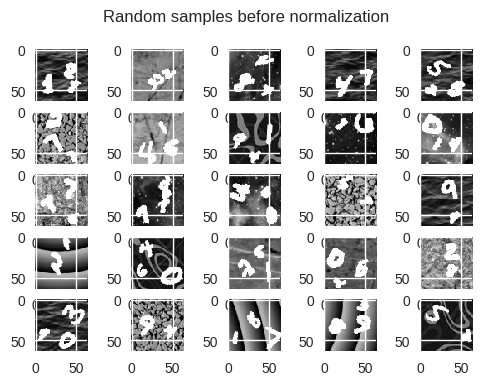

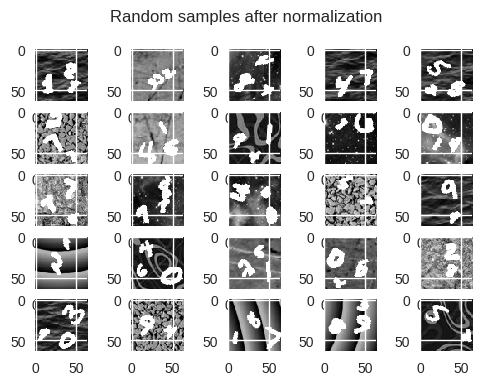

In [0]:
plt.figure(dpi=plot_dpi)
plt.suptitle('Random samples before normalization')
for i in range(num_random_samples[0]):
    for j in range(num_random_samples[1]):
        plt.subplot(num_random_samples[0], num_random_samples[1], i * num_random_samples[1] + j + 1)
        plt.imshow(x_tr_org[idx[i, j]].squeeze().squeeze(), cmap='gray')
plt.show()

plt.figure(dpi=plot_dpi)
plt.suptitle('Random samples after normalization')
for i in range(num_random_samples[0]):
    for j in range(num_random_samples[1]):
        plt.subplot(num_random_samples[0], num_random_samples[1], i * num_random_samples[1] + j + 1)
        plt.imshow(x_tr[idx[i, j]].squeeze().squeeze(), cmap='gray')
plt.show()

In [0]:
del x_tr_org

In [0]:
# # Centering the biggest contour
# x_tr_org = np.copy(x_tr)
# for i, x_i in enumerate(x_tr):
#     x_i = x_i.squeeze().astype(np.uint8)
#     _, contours, _ = cv2.findContours(x_i, 1, 2)
    
#     max_x, max_y, max_w, max_h = 0, 0, 0, 0
#     for contour in contours:
#         x_br, y_br, w_br, h_br = cv2.boundingRect(contour)
#         if w_br * h_br > max_w * max_h:
#             max_x, max_y, max_w, max_h = x_br, y_br, w_br, h_br

#     x_i_bc = np.zeros_like(x_i)
#     x_i_x, x_i_y = (x_i.shape[0] - max_h) // 2, (x_i.shape[1] - max_w) // 2
#     x_i_bc[x_i_x:x_i_x + max_h, x_i_y:x_i_y + max_w] = x_i[max_y:max_y + max_h, max_x:max_x + max_w]
#     x_tr[i] = x_i_bc

# for i, x_i in enumerate(x_ts):
#     x_i = x_i.squeeze().astype(np.uint8)
#     _, contours, _ = cv2.findContours(x_i, 1, 2)
    
#     max_x, max_y, max_w, max_h = 0, 0, 0, 0
#     for contour in contours:
#         x_br, y_br, w_br, h_br = cv2.boundingRect(contour)
#         if w_br * h_br > max_w * max_h:
#             max_x, max_y, max_w, max_h = x_br, y_br, w_br, h_br

#     x_i_bc = np.zeros_like(x_i)
#     x_i_x, x_i_y = (x_i.shape[0] - max_h) // 2, (x_i.shape[1] - max_w) // 2
#     x_i_bc[x_i_x:x_i_x + max_h, x_i_y:x_i_y + max_w] = x_i[max_y:max_y + max_h, max_x:max_x + max_w]
#     x_ts[i] = x_i_bc

In [0]:
# plt.figure(dpi=plot_dpi)
# plt.suptitle('Random samples before centering')
# for i in range(num_random_samples[0]):
#     for j in range(num_random_samples[1]):
#         plt.subplot(num_random_samples[0], num_random_samples[1], i * num_random_samples[1] + j + 1)
#         plt.imshow(x_tr_org[idx[i, j]].squeeze().squeeze(), cmap='gray')
# plt.show()

# plt.figure(dpi=plot_dpi)
# plt.suptitle('Random samples after centering')
# for i in range(num_random_samples[0]):
#     for j in range(num_random_samples[1]):
#         plt.subplot(num_random_samples[0], num_random_samples[1], i * num_random_samples[1] + j + 1)
#         plt.imshow(x_tr[idx[i, j]].squeeze().squeeze(), cmap='gray')
# plt.show()

In [0]:
# del x_tr_org

In [0]:
# Resize to 32x32
# x_tr_org = np.copy(x_tr)
# x_tr = nn.functional.interpolate(torch.from_numpy(x_tr), size=(32, 32)).numpy()

In [0]:
# plt.figure(dpi=plot_dpi)
# plt.suptitle('Random samples before resizing')
# for i in range(num_random_samples[0]):
#     for j in range(num_random_samples[1]):
#         plt.subplot(num_random_samples[0], num_random_samples[1], i * num_random_samples[1] + j + 1)
#         plt.imshow(x_tr_org[idx[i, j]].squeeze().squeeze(), cmap='gray')
# plt.show()

# plt.figure(dpi=plot_dpi)
# plt.suptitle('Random samples after resizing')
# for i in range(num_random_samples[0]):
#     for j in range(num_random_samples[1]):
#         plt.subplot(num_random_samples[0], num_random_samples[1], i * num_random_samples[1] + j + 1)
#         plt.imshow(x_tr[idx[i, j]].squeeze().squeeze(), cmap='gray')
# plt.show()

In [0]:
# del x_tr_org

In [0]:
# max_angle = 10

In [0]:
# Data augmentation
# x_tr_org = np.copy(x_tr)
# y_tr_org = np.copy(y_tr)
# for angle in range(-max_angle, max_angle + 1, 2):
#     x_tr_transformed = np.zeros_like(x_tr_org)
#     for i, x_i in enumerate(x_tr_org):
#         x_i_pil = transforms.functional.to_pil_image(x_i.astype(np.uint8))
#         x_i_transformed_img = transforms.functional.affine(x_i_pil,
#                                                            angle=angle,
#                                                            translate=list(np.random.uniform(-10, 10, size=(2))),
#                                                            scale=np.random.uniform(0.9, 1),
#                                                            shear=0)
#         x_i_transformed = transforms.functional.to_tensor(x_i_transformed_img).numpy()
#     x_tr = np.concatenate([x_tr, x_tr_transformed], axis=0)
#     y_tr = np.concatenate([y_tr, y_tr_org], axis=0)

In [0]:
# print(x_tr.shape)
# print(y_tr.shape)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:0


In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [0]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()  # Initialize
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            Flatten(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.5),

            nn.Linear(2048, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, num_classes),
            nn.Softmax(),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_net(x)
        return x

In [0]:
# Test
test_conv_net = ConvNet(num_classes)
test_x = torch.rand(2, 1, 64, 64)
test_y = test_conv_net(test_x)

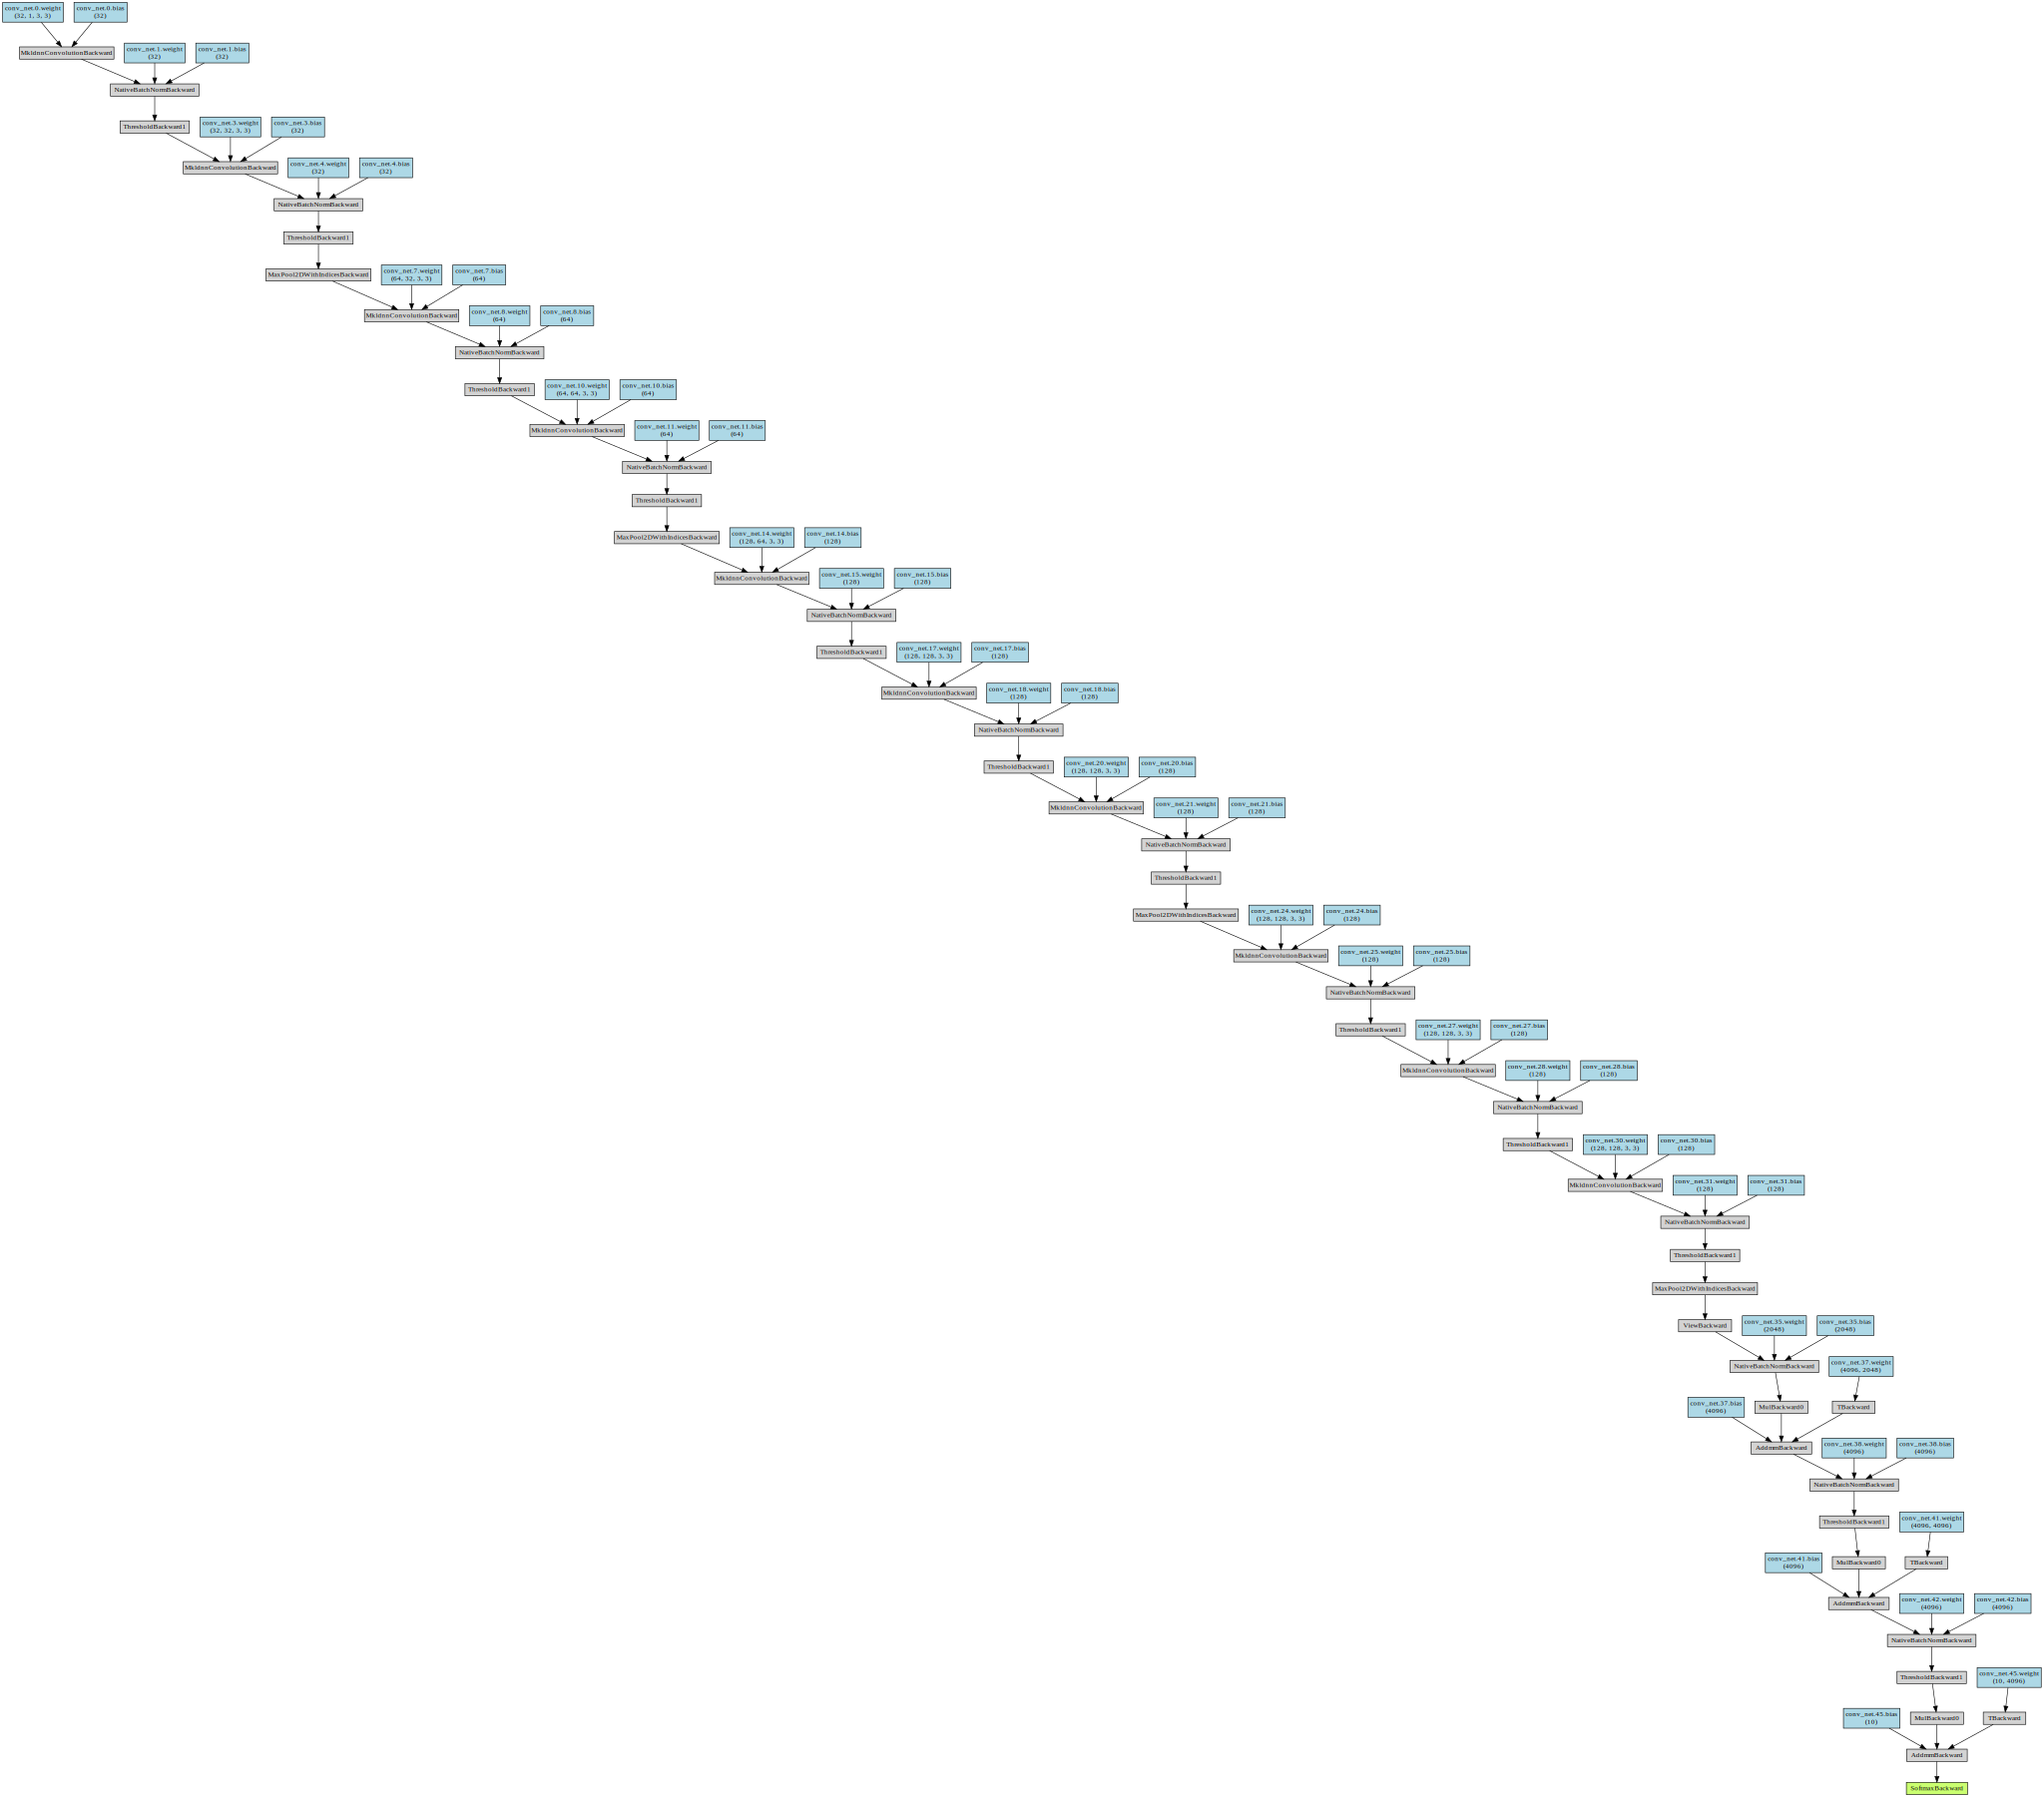

In [0]:
make_dot(test_y, params=dict(test_conv_net.named_parameters()))

In [0]:
assert test_y.size()[1] == num_classes
del test_conv_net, test_x, test_y

In [0]:
class ResNet(resnet.ResNet):
    def __init__(self, num_classes):
        super(ResNet, self).__init__(resnet.BasicBlock, [3, 4, 23, 3], num_classes=num_classes)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        x = super(ResNet, self).forward(x)
        x = torch.softmax(x, dim=-1)
        return x

In [0]:
# Test
test_res_net = ResNet(num_classes)
test_x = torch.rand(2, 1, 64, 64)
test_y = test_res_net(test_x)

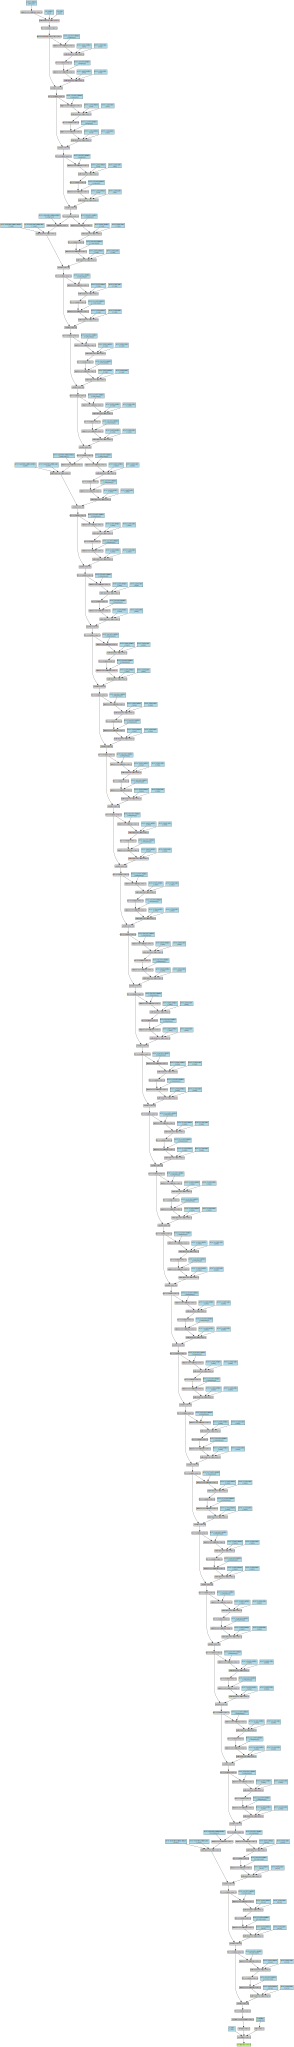

In [0]:
make_dot(test_y, params=dict(test_res_net.named_parameters()))

In [0]:
assert test_y.size()[1] == num_classes
del test_res_net, test_x, test_y

In [0]:
class DenseNet(densenet.DenseNet):
    def __init__(self, num_classes):
        super(DenseNet, self).__init__(num_init_features=16, growth_rate=16, block_config=(6, 12, 24, 16), num_classes=num_classes)
        self.features[0] = torch.nn.Conv2d(1, 16, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        x = super(DenseNet, self).forward(x)
        x = torch.softmax(x, dim=-1)
        return x

In [0]:
# Test
test_dense_net = DenseNet(num_classes)
test_x = torch.rand(2, 1, 64, 64)
test_y = test_dense_net(test_x)

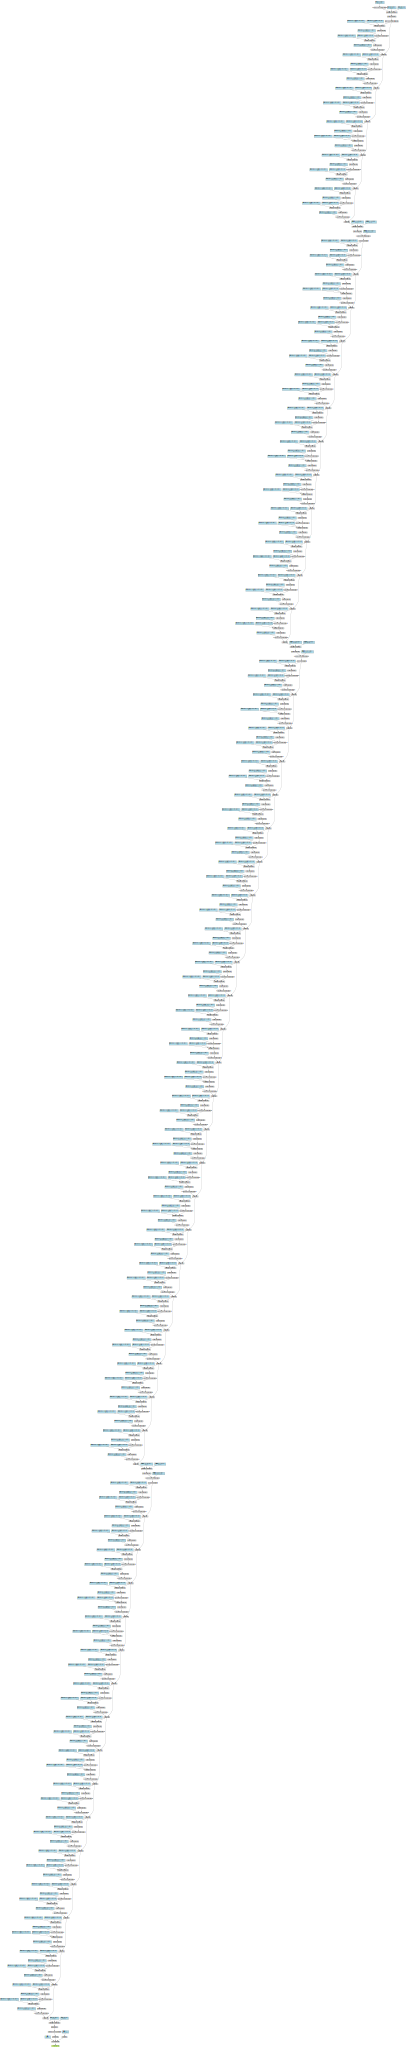

In [0]:
make_dot(test_y, params=dict(test_dense_net.named_parameters()))

In [0]:
assert test_y.size()[1] == num_classes
del test_dense_net, test_x, test_y

In [0]:
class SqueezeNet(squeezenet.SqueezeNet):
    def __init__(self, num_classes):
        super(SqueezeNet, self).__init__(version=1.1, num_classes=num_classes)
        self.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=2)

    def forward(self, x):
        x = super(SqueezeNet, self).forward(x)
        return x

In [0]:
# Test
test_squeeze_net = SqueezeNet(num_classes)
test_x = torch.rand(2, 1, 64, 64)
test_y = test_squeeze_net(test_x)

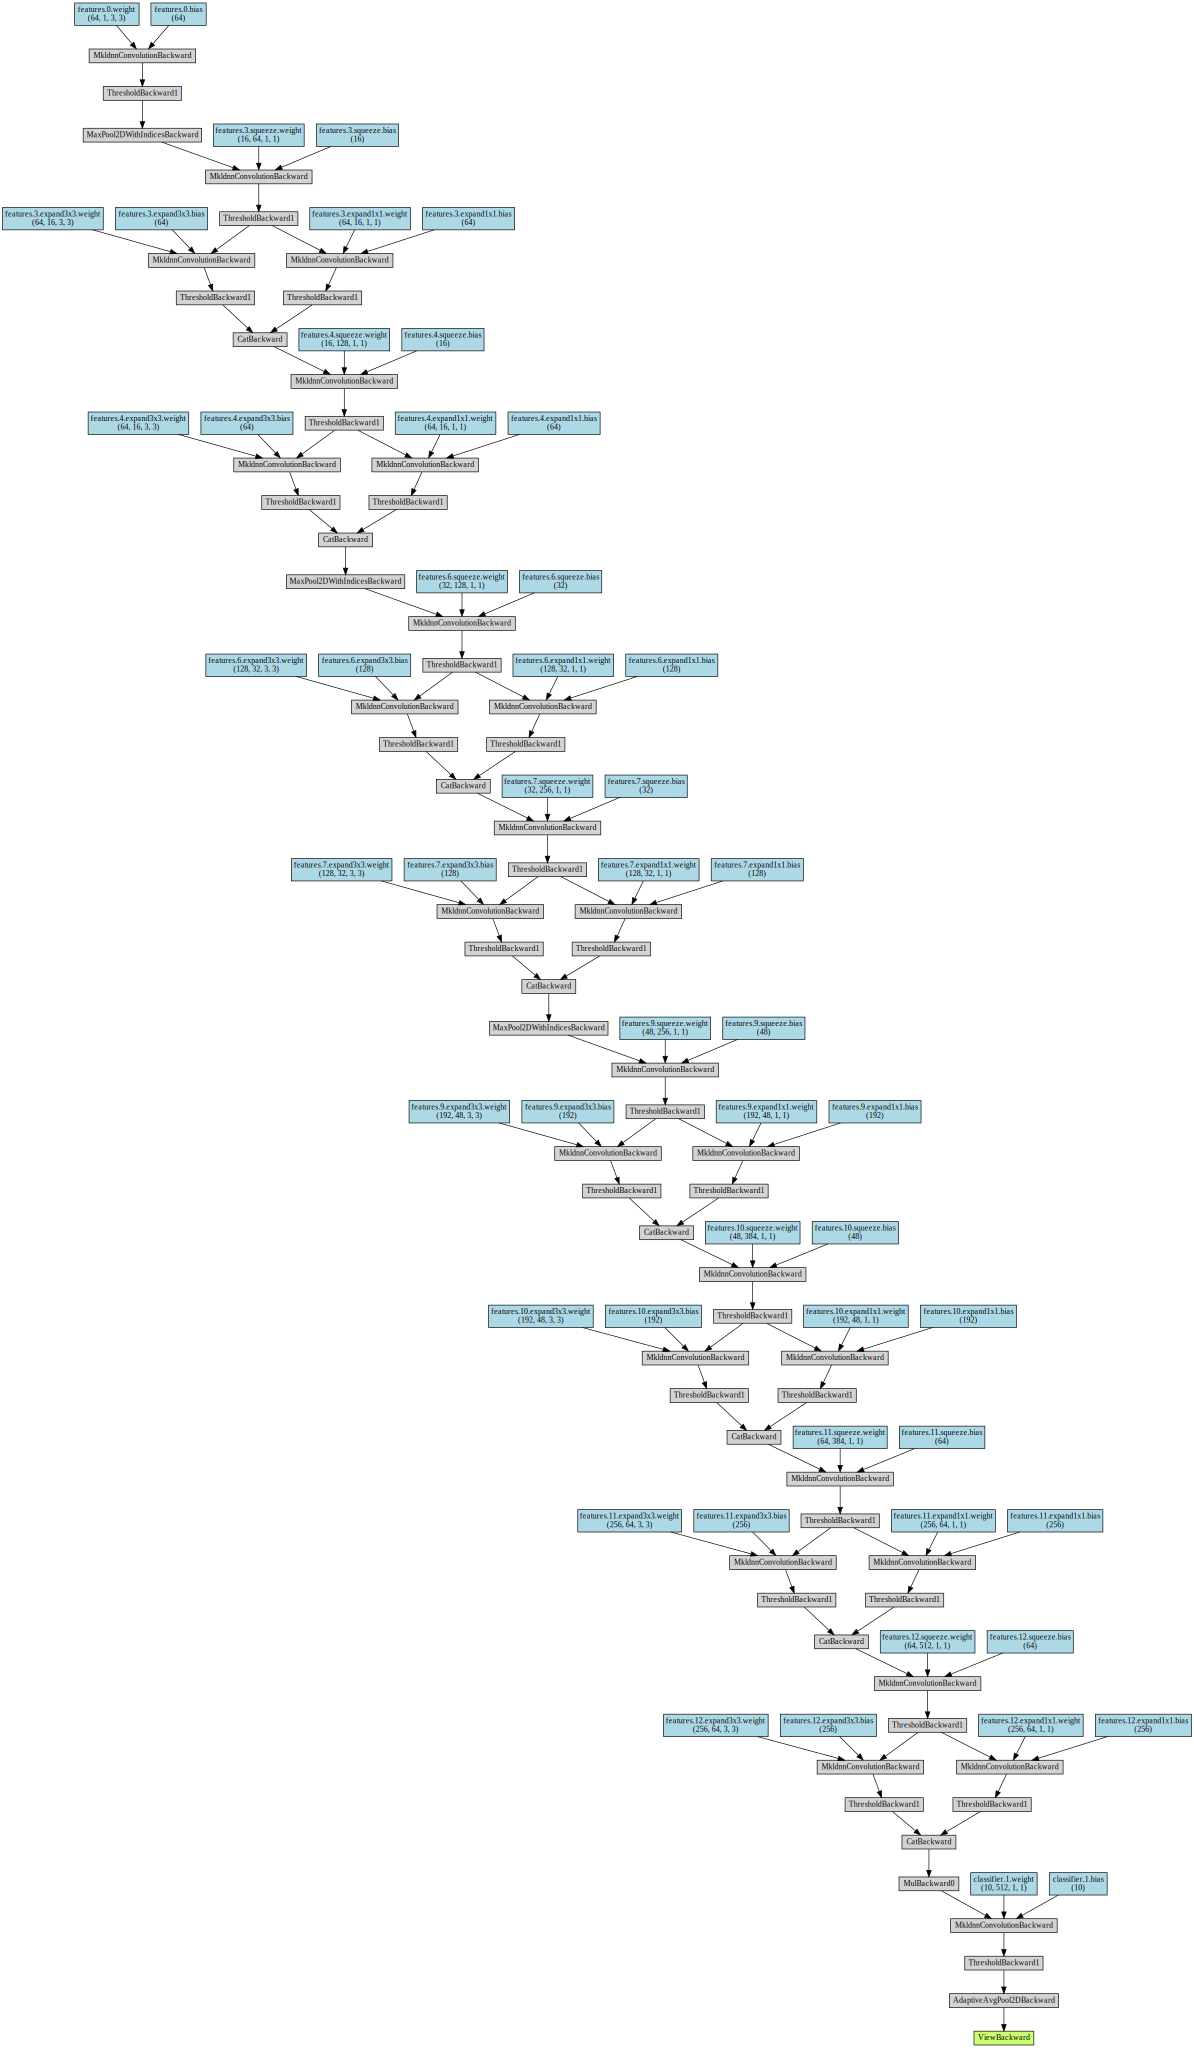

In [0]:
make_dot(test_y, params=dict(test_squeeze_net.named_parameters()))

In [0]:
assert test_y.size()[1] == num_classes
del test_squeeze_net, test_x, test_y

In [0]:
def cross_validate(x_tr, y_tr, clf, params, clf_name):
    tr_loss_hist, cv_loss_hist = [], []
    tr_acc_hist, cv_acc_hist = [], []

    tr_idx, cv_idx = next(StratifiedShuffleSplit(n_splits=1, test_size=test_size).split(x_tr, y_tr))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params)

    try:
        best_cv_acc = 0
        for epoch in range(epochs):
            st_time = datetime.now()

            clf.train()

            running_loss, running_corrects = 0, 0
            num_mini_batches = tr_idx.shape[0] / mini_batch_size
            np.random.shuffle(tr_idx)  # NOTE: Shuffle train to prevent using same batches everytime
            for mini_batch, mini_batch_idx in enumerate(np.split(tr_idx, num_mini_batches)):
                x_mini_batch = torch.from_numpy(x_tr[mini_batch_idx]).to(device)
                y_mini_batch = torch.from_numpy(y_tr[mini_batch_idx]).long().to(device)

                y_pred = clf(x_mini_batch)

                loss = criterion(y_pred, y_mini_batch)
                running_loss += loss.data.item()

                _, y_pred = torch.max(y_pred, 1)

                corrects = (y_pred == y_mini_batch).float().sum()
                running_corrects += corrects

                optimizer.zero_grad()  # Reset gradients so it wouldn't be accumulated
                loss.backward()  # Calculate gradients
                optimizer.step()  # Update the weights
                
                del x_mini_batch, y_mini_batch, y_pred, loss, corrects

            mean_loss = running_loss / tr_idx.shape[0]
            tr_loss_hist.append(mean_loss)

            accuracy = running_corrects / tr_idx.shape[0]
            tr_acc_hist.append(accuracy)
            
            time = datetime.now() - st_time

            print(f'epoch: {epoch + 1: >{len(str(epochs))}}/{epochs}, time: {time}, loss: {mean_loss}, accuracy: {accuracy}')

            if (epoch + 1) % checkpoint_epochs == 0:
                clf.eval()

                running_loss, running_corrects = 0, 0
                num_mini_batches = cv_idx.shape[0] / mini_batch_size_cv
                for mini_batch, mini_batch_idx in enumerate(np.split(cv_idx, num_mini_batches)):
                    x_mini_batch = torch.from_numpy(x_tr[mini_batch_idx]).to(device)
                    y_mini_batch = torch.from_numpy(y_tr[mini_batch_idx]).long().to(device)

                    y_pred = clf(x_mini_batch)

                    loss = criterion(y_pred, y_mini_batch)
                    running_loss += loss.data.item()

                    _, y_pred = torch.max(y_pred, 1)

                    corrects = (y_pred == y_mini_batch).float().sum()
                    running_corrects += corrects

                    del x_mini_batch, y_mini_batch, y_pred, loss, corrects

                mean_loss = running_loss / cv_idx.shape[0]
                cv_loss_hist.append(mean_loss)

                accuracy = running_corrects / cv_idx.shape[0]
                cv_acc_hist.append(accuracy)

                if accuracy > best_cv_acc:
                    best_cv_acc = accuracy
                    torch.save(clf, checkpoint_path.format(clf_name))

                print(f'epoch: {epoch + 1: >{len(str(epochs))}}/{epochs}, cv loss: {mean_loss}, cv accuracy: {accuracy}')
    except KeyboardInterrupt:
        pass
    return tr_loss_hist, cv_loss_hist, tr_acc_hist, cv_acc_hist

In [0]:
test_size = 0.1

epochs = 200
mini_batch_size = 256
mini_batch_size_cv = 250

checkpoint_epochs = 10
checkpoint_path = './checkpoints/{}.pt'
checkpoint_name = 'squeezenet_e200'

num_clfs = 1

In [0]:
clf_names, tr_loss_hists, cv_loss_hists, tr_acc_hists, cv_acc_hists = [], [], [], [], []
for i in range(num_clfs):
    clf_names.append(f'{checkpoint_name}_{i}')
    clf = ConvNet(num_classes).float().to(device=device)
    tr_loss_hist, cv_loss_hist, tr_acc_hist, cv_acc_hist = cross_validate(x_tr, y_tr, clf, clf.parameters(), clf_names[-1])
    tr_loss_hists.append(tr_loss_hist), cv_loss_hists.append(cv_loss_hist)
    tr_acc_hists.append(tr_acc_hist), cv_acc_hists.append(cv_acc_hist)
    del clf

epoch:   1/200, time: 0:02:46.582614, loss: 0.008759405453999837, accuracy: 0.19574999809265137


In [0]:
print('Stats length before adjusing')
for i in range(num_clfs):
    print(len(tr_loss_hists[i]), len(tr_acc_hists[i]), len(cv_loss_hists[i]), len(cv_acc_hists[i]))

In [0]:
ran_epochs = []
for i in range(num_clfs):
    ran_epochs.append(len(cv_acc_hists[i]) * checkpoint_epochs)
    tr_loss_hists[i] = tr_loss_hists[i][:ran_epochs[-1]]
    tr_acc_hists[i] = tr_acc_hists[i][:ran_epochs[-1]]
    cv_loss_hists[i] = cv_loss_hists[i][:ran_epochs[-1] // checkpoint_epochs]
    cv_acc_hists[i] = cv_acc_hists[i][:ran_epochs[-1] // checkpoint_epochs]

In [0]:
print('Stats length after adjusing')
for i in range(num_clfs):
    print(len(tr_loss_hists[i]), len(tr_acc_hists[i]), len(cv_loss_hists[i]), len(cv_acc_hists[i]))

In [0]:
for i in range(num_clfs):
    plt.figure(dpi=plot_dpi)
    plt.grid(None)
    plt.title('Training Metrics')

    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(list(range(1, ran_epochs[i] + 1)), tr_loss_hists[i])
    plt.plot(list(range(checkpoint_epochs, ran_epochs[i] + 1, checkpoint_epochs)), cv_loss_hists[i])
    plt.legend(['train', 'cross validation'], loc='upper right')

    plt.subplot(2, 1, 2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(list(range(1, ran_epochs[i] + 1)), tr_acc_hists[i])
    plt.plot(list(range(checkpoint_epochs, ran_epochs[i] + 1, checkpoint_epochs)), cv_acc_hists[i])
    plt.legend(['train', 'cross validation'], loc='lower right')
    plt.show()

In [0]:
del tr_loss_hists, cv_loss_hists, tr_acc_hists, cv_acc_hists

In [0]:
torch.cuda.empty_cache()

In [0]:
import gc

gc.collect()

39645

In [0]:
def predict(x_ts, clf_names):
    y_preds = np.zeros((x_ts.shape[0], len(clf_names) * num_classes))
    for i, clf_name in enumerate(clf_names):
        clf = torch.load(checkpoint_path.format(clf_name), map_location=device)
        clf.eval()

        with torch.no_grad():
            num_mini_batches = x_ts.shape[0] / mini_batch_size_ts
            for mini_batch, x_mini_batch in enumerate(np.split(x_ts, num_mini_batches)):
                x_mini_batch = torch.from_numpy(x_mini_batch).to(device)

                y_pred = clf(x_mini_batch).cpu().numpy()  # Calculate output of test in one-hot format
                row = mini_batch * mini_batch_size_ts
                col = i * num_classes
                y_preds[row:row + mini_batch_size_ts, col:col + num_classes] = y_pred

                del x_mini_batch, y_pred
            del clf
    return y_preds

In [0]:
def to_categorial(y_preds):
    y_pred = np.zeros((y_preds.shape[0],), dtype=np.int64)
    for i in range(y_pred.shape[0]):
        y_pred[i] = np.argmax(np.bincount(y_preds[i].astype(np.int64)))
    return y_pred

In [0]:
mini_batch_size_ts = 1000

In [0]:
clf_names = []
for i in range(10):
    clf_names.append(f'resnet18_e200_{i}')
for i in range(14):
    clf_names.append(f'vgg11_e200_{i}')
for i in range(1):
    clf_names.append(f'resnet101_e200_{i}')

In [0]:
y_tr_pred = predict(x_tr, clf_names)
y_ts = predict(x_ts, clf_names)

In [0]:
print(y_tr_pred.shape)
print(y_ts.shape)

(40000, 250)
(10000, 250)


In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

# LinearSVC -> 0.05
# LogisticRegression -> 0.3

tr_idx, cv_idx = next(StratifiedShuffleSplit(n_splits=1, test_size=0.1).split(y_tr_pred, y_tr))
clf = LinearSVC(C=0.1)
clf.fit(y_tr_pred[tr_idx], y_tr[tr_idx])
print(f'train acc: {(clf.predict(y_tr_pred[tr_idx]) == y_tr[tr_idx]).sum() / len(tr_idx)}')
print(f'cv acc: {(clf.predict(y_tr_pred[cv_idx]) == y_tr[cv_idx]).sum() / len(cv_idx)}')

train acc: 0.9934444444444445
cv acc: 0.9905


In [0]:
clf = LinearSVC(C=0.05)
clf.fit(y_tr_pred, y_tr)
print(f'train acc: {(clf.predict(y_tr_pred[tr_idx]) == y_tr[tr_idx]).sum() / len(tr_idx)}')

train acc: 0.9923055555555556


In [0]:
y_ts_pred = clf.predict(y_ts)

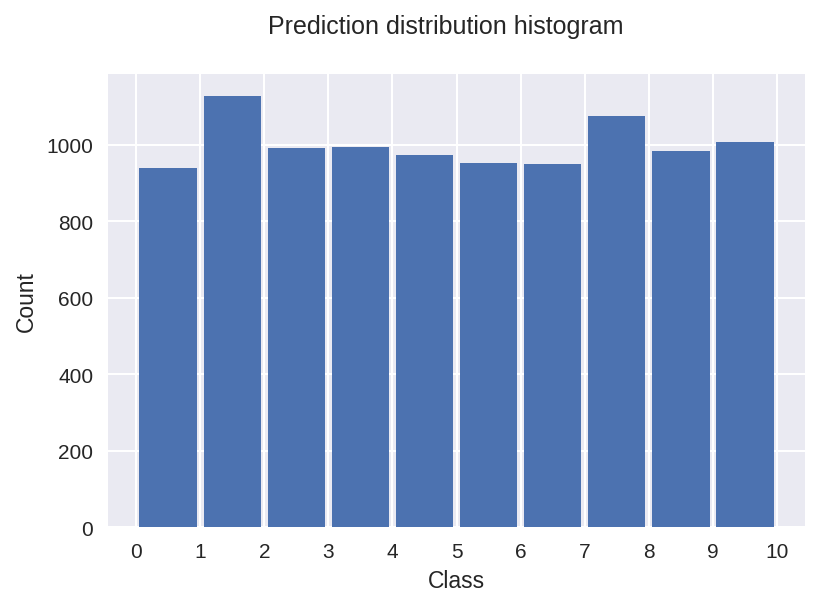

In [0]:
plt.figure(dpi=150)
plt.suptitle('Prediction distribution histogram')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(11))
plt.hist(y_ts_pred, bins=range(11), histtype='bar', rwidth=0.9)
plt.show()

In [0]:
result_path = './results/{}.csv'
result_name = 'linear_svc_bagging'

In [0]:
with open(result_path.format(result_name), 'w') as f:
    f.write('Id,Category\n')
    for i, y_ts_i in enumerate(y_ts_pred):
        f.write('{},{}\n'.format(i, y_ts_i))

In [0]:
del y_ts

In [0]:
from google.colab import files

files.download(result_path.format(result_name))